# Accuracy graphic

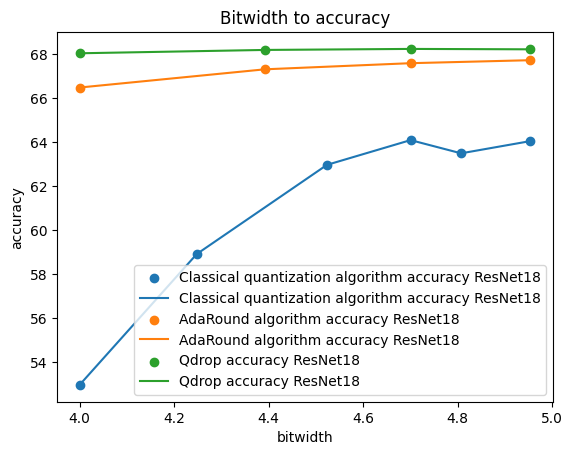

In [1]:
import numpy as np
accuracy = {"Classical quantization algorithm accuracy ResNet18" : {4 : 52.961997985839844, 
                                                                    np.log2(2**4+3) : 58.90599822998047, 
                                                                    np.log2(2**4+7) : 62.95800018310547, 
                                                                    np.log2(2**4+10) : 64.08200073242188,
                                                                    np.log2(2**4+12) : 63.481998443603516,
                                                                    np.log2(2**4+15) : 64.03800201416016},
            "AdaRound algorithm accuracy ResNet18" : {4 : 66.47000122070312,   np.log2(2**4+5) : 67.2979965209961 , np.log2(2**4+10) : 67.57599639892578, np.log2(2**4+15) : 67.71199798583984},
            "Qdrop accuracy ResNet18": {4 : 68.0260009765625, np.log2(2**4+5) : 68.1780014038086 , np.log2(2**4+10) : 68.2239990234375, np.log2(2**4+15) : 68.20600128173828}}


import matplotlib.pyplot as plt
plt.title('Bitwidth to accuracy')
for label, bits_to_accs in accuracy.items():
    plt.scatter(bits_to_accs.keys(), bits_to_accs.values(), label=label)
    plt.plot(bits_to_accs.keys(), bits_to_accs.values(), label=label)

plt.xlabel('bitwidth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# l2 metric between weight and quantized weight

Load model

In [20]:
import hubconf
resnet18 = eval('hubconf.{}(pretrained=True)'.format('resnet18'))
resnet18.eval()
cnn_weight = torch.flatten(resnet18.layer1[0].conv1.weight)


Initialize quantizer

In [23]:
import torch
import numpy as np
from QDrop.quant.quant_layer import QuantModule, UniformAffineQuantizer, round_ste
wq_params = {'n_bits': 4, 'channel_wise': False, 'scale_method': 'mse', 'quantize_clipped':False}

quantizer = UniformAffineQuantizer(**wq_params)
quantizer.num=1000

Count l2 metric

In [27]:
delta_to_score = {}
delta_to_bitwidth = {}

x = cnn_weight

x_min, x_max = torch._aminmax(x)
max_val = 2*max(-x_min, x_max)

best_score = torch.zeros_like(x_min) + (1e+10)
best_max = max_val
best_min = -max_val
delta = (best_max - best_min) / (2 ** quantizer.n_bits - 2)
best_min -= delta

for i in range(1, quantizer.num + 1):
    new_max =  max_val / quantizer.num * i
    new_min = -new_max
    delta = (new_max - new_min) / (2 ** quantizer.n_bits - 2)
    new_min -= delta
    pos_levels = min(max(round_ste(x_max/delta).cpu().detach() + 1, 2**(quantizer.n_bits-1)), 2**quantizer.n_bits-1)
    neq_levels = min(max(round_ste(-x_min/delta).cpu().detach(), 2**(quantizer.n_bits-1)), 2**quantizer.n_bits)

    n_levels = np.log2(pos_levels + neq_levels)
    delta_to_bitwidth[delta.item()] = n_levels

    x_q = quantizer.quantize(x, new_max, new_min)
    clipped_x_q = quantizer.quantize(torch.clamp(x-new_min, max=0)+torch.clamp(x-new_max, min=0), new_max, new_min)
    score = quantizer.lp_loss(x, x_q + clipped_x_q, 2)
    best_max = torch.where(score < best_score, new_max, best_max)
    best_min = torch.where(score < best_score, new_min, best_min)
    best_score = torch.min(score, best_score)

    delta_to_score[delta.item()] = score.item()


Plot

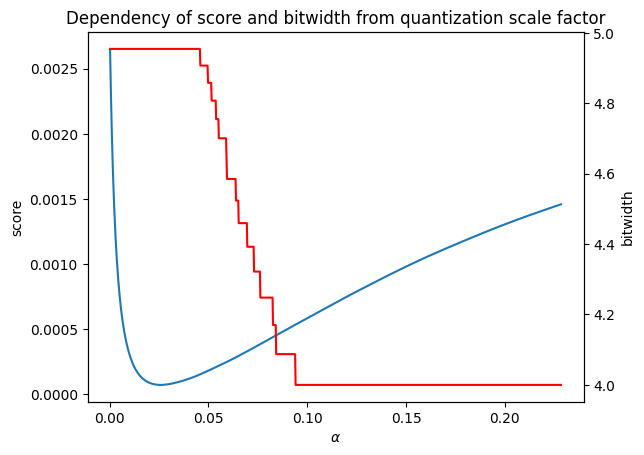

In [31]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
plt.title("Dependency of score and bitwidth from quantization scale factor")
ax.plot(delta_to_score.keys(), delta_to_score.values(), label='l2-score')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('score')
ax2=ax.twinx()
ax2.plot(delta_to_bitwidth.keys(), delta_to_bitwidth.values(), color='red', label='bitwidth')
ax2.set_ylabel('bitwidth')

plt.show()